In [1]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./time_series_covid19_confirmed_global.csv')

In [3]:
data.drop('Province/State', axis=1, inplace=True)
data.drop('Lat', axis=1, inplace=True)
data.drop('Long', axis=1, inplace=True)
data.columns = np.concatenate((np.array(['Country/Region']),np.arange(len(data.columns[1:]))))

In [4]:
data

,Country/Region,0,1,2,3,4,5,6,7,8,...,566,567,568,569,570,571,572,573,574,575
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,151013,151291,151563,151770,151770,151770,152142,152243,152363,152411
1,Albania,0,0,0,0,0,0,0,0,0,...,134201,134487,134761,135140,135550,135947,136147,136598,137075,137597
2,Algeria,0,0,0,0,0,0,0,0,0,...,183347,184191,185042,185902,186655,187258,187968,188663,189384,190078
3,Andorra,0,0,0,0,0,0,0,0,0,...,14873,14891,14908,14924,14924,14924,14954,14960,14976,14981
4,Angola,0,0,0,0,0,0,0,0,0,...,43890,43998,44174,44328,44534,44617,44739,44972,45175,45325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,Vietnam,0,2,2,2,2,2,2,2,2,...,232937,241543,246568,255748,265464,275044,283696,293301,302101,312611
275,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,318181,318435,319223,319646,320034,320034,321031,321031,322620,323582
276,Yemen,0,0,0,0,0,0,0,0,0,...,7198,7213,7233,7256,7273,7293,7308,7347,7372,7407
277,Zambia,0,0,0,0,0,0,0,0,0,...,200830,201342,201770,201867,202078,202261,202429,202787,203169,203553


In [5]:
Confirmed = {'Brazil':[],'India':[],'United Kingdom':[],'Russia':[],'US':[]}
for index,row in data.iterrows():
    for key in Confirmed:
        if row['Country/Region'] == key:
            d = data.iloc[index][1:].astype(np.float32).values
            m = np.zeros_like(d)
            for j in range(1,len(d)):
                m[j] = d[j] - d[j-1]
            Confirmed[key].append(m)

In [6]:
print(len(Confirmed['Brazil']))
print(len(Confirmed['India']))
print(len(Confirmed['United Kingdom']))
print(len(Confirmed['US']))
print(len(Confirmed['Russia']))
timeLength = len(Confirmed['Brazil'][0])
print(timeLength)

1
1
12
1
1
576


In [7]:
Confirmed['United Kingdom'] = [np.sum(np.array(Confirmed['United Kingdom']),axis=0)]

Text(0.5, 1.0, 'Number of confirmed cases in a single day in Brazil')

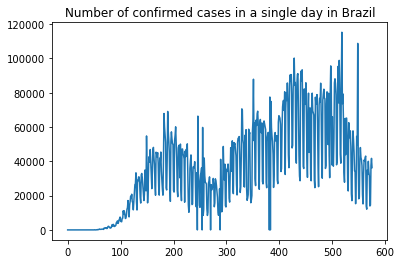

In [8]:
plt.plot(Confirmed['Brazil'][0])
plt.title('Number of confirmed cases in a single day in Brazil')

In [9]:
sequence_length= 10
delay = 1
def func(country):
    dataCountry = []
    for i in range(timeLength - sequence_length -delay + 1):
        dataCountry.append(Confirmed[country][0][i:i+sequence_length+delay])
    dataCountry = np.array(dataCountry)
    x_train = dataCountry[:,:sequence_length]
    y_train = dataCountry[:,-1]
    return np.expand_dims(x_train,2),y_train

In [10]:
x_Brazil,y_Brazil = func('Brazil')
x_India,y_India = func('India')
x_Russia,y_Russia = func('Russia')
x_UK,y_UK = func('United Kingdom')
x_US,y_US = func('US')

In [11]:
def norm(country,x,y):
    x = x / np.max(Confirmed[country][0])
    y = y / np.max(Confirmed[country][0])
    return x, y

In [12]:
x_Brazil, y_Brazil = norm('Brazil',x_Brazil, y_Brazil)
x_India, y_India = norm('India',x_India, y_India)
x_Russia, y_Russia = norm('Russia',x_Russia, y_Russia)
x_UK, y_UK = norm('United Kingdom',x_UK, y_UK)
x_US, y_US = norm('US',x_US,y_US)

In [13]:
from sklearn.model_selection import train_test_split
train_x_Brazil,test_x_Brazil,train_y_Brazil,test_y_Brazil = train_test_split(x_Brazil,y_Brazil)
train_x_India,test_x_India,train_y_India,test_y_India = train_test_split(x_India,y_India)
train_x_Russia,test_x_Russia,train_y_Russia,test_y_Russia = train_test_split(x_Russia,y_Russia)
train_x_UK,test_x_UK,train_y_UK,test_y_UK = train_test_split(x_UK,y_UK)
train_x_US,test_x_US,train_y_US,test_y_US = train_test_split(x_US,y_US)

In [14]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return len(self.features)

In [15]:
train_Brazil_dataset = Mydataset(train_x_Brazil,train_y_Brazil)
test_Brazil_dataset = Mydataset(test_x_Brazil,test_y_Brazil)
train_India_dataset = Mydataset(train_x_India,train_y_India)
test_India_dataset = Mydataset(test_x_India,test_y_India)
train_Russia_dataset = Mydataset(train_x_Russia,train_y_Russia)
test_Russia_dataset = Mydataset(test_x_Russia,test_y_Russia)
train_UK_dataset = Mydataset(train_x_UK,train_y_UK)
test_UK_dataset = Mydataset(test_x_UK,test_y_UK)
train_US_dataset = Mydataset(train_x_US,train_y_US)
test_US_dataset = Mydataset(test_x_US,test_y_US)

In [16]:
BTACH_SIZE = 64
train_Brazil_dl = torch.utils.data.DataLoader(train_Brazil_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_Brazil_dl = torch.utils.data.DataLoader(test_Brazil_dataset,batch_size=BTACH_SIZE)
train_India_dl = torch.utils.data.DataLoader(train_India_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_India_dl = torch.utils.data.DataLoader(test_India_dataset,batch_size=BTACH_SIZE)
train_Russia_dl = torch.utils.data.DataLoader(train_Russia_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_Russia_dl = torch.utils.data.DataLoader(test_Russia_dataset,batch_size=BTACH_SIZE)
train_UK_dl = torch.utils.data.DataLoader(train_UK_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_UK_dl = torch.utils.data.DataLoader(test_UK_dataset,batch_size=BTACH_SIZE)
train_US_dl = torch.utils.data.DataLoader(train_US_dataset,batch_size=BTACH_SIZE,shuffle=True)
test_US_dl = torch.utils.data.DataLoader(test_US_dataset,batch_size=BTACH_SIZE)

In [17]:
hidden_size = 128
class Net(nn.Module):
    # GRU实现 
    def __init__(self,hidden_size):
        super().__init__()
        self.num_layers = 3
        self.rnn = nn.GRU(1,hidden_size,num_layers=self.num_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.coff = nn.Parameter(torch.ones(1).squeeze()/2,requires_grad=True)
    def forward(self,inputs):
        _,hn = self.rnn(inputs)
        x = F.dropout(F.relu(self.fc1(hn)))
        x = self.fc2(x)
        x = torch.sum(x,axis=0)
        x = F.relu(x)

        with torch.no_grad():
            m = list() 
            for ele in inputs:
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                if device == 'cuda':
                    ele = ele.squeeze().cpu().detach().numpy()
                else:
                    ele = ele.squeeze().detach().numpy()
                res = self.ES_Forecast(ele,1)
                m.append([res])
            m = torch.as_tensor(m,dtype=torch.float32).to(device)
        x = torch.cat((x,m),dim=1)
        x = self.coff*x[:,0]+(1 - self.coff)*x[:,1]
#         x = torch.mean(x,dim=1)
#         x = self.mix1(x)
#         x = self.mix2(x)
        x = F.relu(x)
        return x.squeeze()
    def ES_Forecast(self,A,T):
        yt,n = A,len(A)
        alpha, st1_0 = 0.3,np.mean(yt[0:3])
        st2_0, st3_0 = st1_0, st1_0
        st1,st2,st3 = list(),list(),list()
        st1.append(alpha*yt[0]+(1-alpha)*st1_0)
        st2.append(alpha*st1[0]+(1-alpha)*st2_0)
        st3.append(alpha*st2[0]+(1-alpha)*st3_0)
        for i in range(1,n):
            st1.append(alpha*yt[i]+(1-alpha)*st1[i-1])
            st2.append(alpha*st1[i]+(1-alpha)*st2[i-1])
            st3.append(alpha*st2[i]+(1-alpha)*st3[i-1])
        a = 3*st1[-1] - 3*st2[-1]+st3[-1]
        b = 0.5*alpha/((1-alpha)**2)*((6-5*alpha)*st1[-1]-2*(5-4*alpha)*st2[-1]+(4-3*alpha)*st3[-1])
        c = 0.5*alpha**2/(1-alpha)**2*(st1[-1]-2*st2[-1]+st3[-1])
        coff = [c,b,a]
        res = c*T**2+b*T+a
        return res
        
# class Net(nn.Module):
#     # LSTM实现 
#     def __init__(self, hidden_size):
#         super(Net, self).__init__()
#         self.rnn = nn.LSTM(1, hidden_size,num_layers=4,batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 256)
#         self.fc2 = nn.Linear(256, 1)

#     def forward(self, inputs):
#         _, s_o = self.rnn(inputs)
#         s_o = s_o[-1]
#         x = F.dropout(F.relu(self.fc1(s_o)))
#         x = self.fc2(x)
#         x = torch.sum(x,axis=0)
#         return torch.squeeze(x)

In [18]:
model_Brazil = Net(hidden_size)
model_India = Net(hidden_size)
model_Russia = Net(hidden_size)
model_UK = Net(hidden_size)
model_US = Net(hidden_size)

In [19]:
if torch.cuda.is_available():
    model_India.to('cuda')
    model_Brazil.to('cuda')
    model_Russia.to('cuda')
    model_UK.to('cuda')
    model_US.to('cuda')

In [20]:
loss_fn = nn.MSELoss()
optimizer_Brazil = torch.optim.Adam(model_Brazil.parameters(), lr=5e-4)
optimizer_India = torch.optim.Adam(model_India.parameters(), lr=5e-4)
optimizer_Russia = torch.optim.Adam(model_Russia.parameters(), lr=5e-4)
optimizer_UK = torch.optim.Adam(model_UK.parameters(), lr=5e-4)
optimizer_US = torch.optim.Adam(model_US.parameters(), lr=5e-4)

In [21]:
def fit(epoch, model, trainloader, testloader,optimizer):
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
        
#     print('epoch: ', epoch, 
#           'loss： ', round(epoch_loss, 6),
#           'test_loss： ', round(epoch_test_loss, 6),
#              )
        
    return epoch_loss, epoch_test_loss

In [22]:
def pltLoss(train_loss,test_loss):
    plt.figure()
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train_loss','test_loss'])

In [23]:
train_loss = []
test_loss = []
epochs = 200
bestModel_Brazil = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_Brazil,train_Brazil_dl,test_Brazil_dl,optimizer_Brazil)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_Brazil = model_Brazil

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.92it/s]


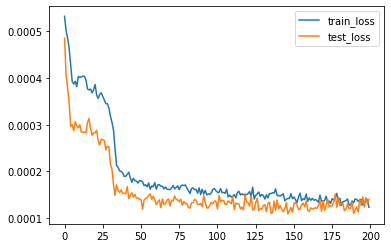

In [24]:
pltLoss(train_loss,test_loss)

In [25]:
train_loss = []
test_loss = []
epochs = 200
bestModel_India = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_India,train_India_dl,test_India_dl,optimizer_India)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss < bestLoss:
        bestLoss = epoch_test_loss
        bestModel_India = model_India

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.93it/s]


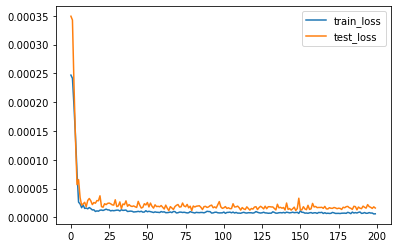

In [26]:
pltLoss(train_loss,test_loss)

In [27]:
train_loss = []
test_loss = []
epochs = 200
bestModel_Russia = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_Russia,train_Russia_dl,test_Russia_dl,optimizer_Russia)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_Russia = model_Russia

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.91it/s]


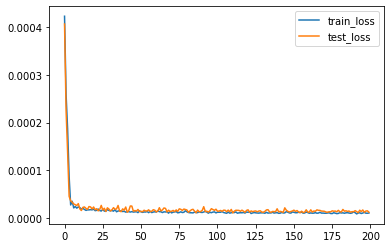

In [28]:
pltLoss(train_loss,test_loss)

In [29]:
train_loss = []
test_loss = []
epochs = 200
bestModel_UK = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_UK,train_UK_dl,test_UK_dl,optimizer_UK)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_UK = model_UK

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.92it/s]


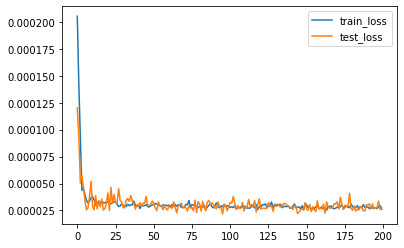

In [30]:
pltLoss(train_loss,test_loss)

In [31]:
train_loss = []
test_loss = []
epochs = 200
bestModel_US = None
bestLoss = np.inf
for epoch in tqdm(range(epochs),total=epochs,smoothing=0.9):
    epoch_loss, epoch_test_loss = fit(epoch,model_US,train_US_dl,test_US_dl,optimizer_US)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)
    if epoch_test_loss<bestLoss:
        bestLoss = epoch_test_loss
        bestModel_US = model_US

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.91it/s]


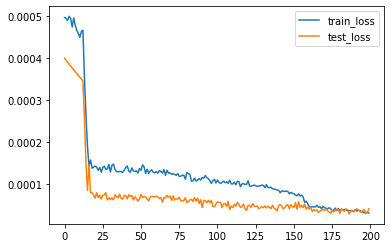

In [32]:
pltLoss(train_loss,test_loss)

# India Brazil Russia UK US未来预测

In [33]:
x4pred_bra = Confirmed['Brazil'][0][-sequence_length:]/np.max(Confirmed['Brazil'][0])
x4pred_ind = Confirmed['India'][0][-sequence_length:]/np.max(Confirmed['India'][0])
x4pred_rus = Confirmed['Russia'][0][-sequence_length:]/np.max(Confirmed['Russia'][0])
x4pred_UK = Confirmed['United Kingdom'][0][-sequence_length:]/np.max(Confirmed['United Kingdom'][0])
x4pred_US = Confirmed['US'][0][-sequence_length:]/np.max(Confirmed['US'][0])
ptr = 0
POINT_NUM = 61
while ptr<POINT_NUM:
    x_input = np.expand_dims(x4pred_bra[ptr:ptr+sequence_length],(0,2))
    out = bestModel_Brazil(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,)
    x4pred_bra = np.concatenate((x4pred_bra,out))
    
    x_input = np.expand_dims(x4pred_ind[ptr:ptr+sequence_length],(0,2))
    out = bestModel_India(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,)
    x4pred_ind = np.concatenate((x4pred_ind,out))
    
    x_input = np.expand_dims(x4pred_rus[ptr:ptr+sequence_length],(0,2))
    out = bestModel_Russia(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,)
    x4pred_rus = np.concatenate((x4pred_rus,out))
    
    x_input = np.expand_dims(x4pred_US[ptr:ptr+sequence_length],(0,2))
    out = bestModel_US(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,)
    x4pred_US = np.concatenate((x4pred_US,out))
    
    x_input = np.expand_dims(x4pred_UK[ptr:ptr+sequence_length],(0,2))
    out = bestModel_UK(torch.as_tensor(x_input,dtype=torch.float).cuda())
    out = out.cpu().detach().numpy().reshape(1,)
    x4pred_UK = np.concatenate((x4pred_UK,out))
    
    ptr += 1
x4pred_bra = x4pred_bra[-POINT_NUM:]*np.max(Confirmed['Brazil'][0])
x4pred_ind = x4pred_ind[-POINT_NUM:]*np.max(Confirmed['India'][0])
x4pred_rus = x4pred_rus[-POINT_NUM:]*np.max(Confirmed['Russia'][0])
x4pred_US = x4pred_US[-POINT_NUM:]*np.max(Confirmed['US'][0])
x4pred_UK = x4pred_UK[-POINT_NUM:]*np.max(Confirmed['United Kingdom'][0])

In [34]:
def mPlot(string,d):
    plt.figure()
    plt.plot(np.arange(timeLength),Confirmed[string][0])
    plt.plot(np.arange(timeLength,timeLength+POINT_NUM),d)

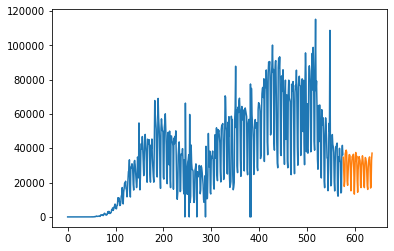

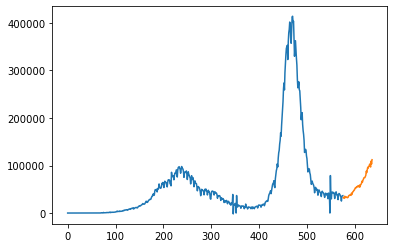

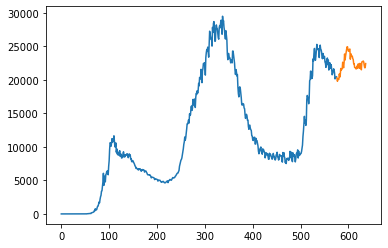

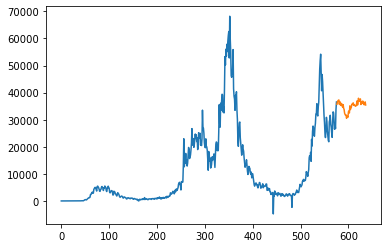

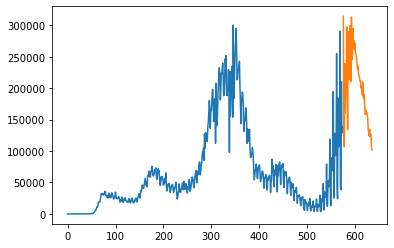

In [35]:
mPlot('Brazil',x4pred_bra)
mPlot('India',x4pred_ind)
mPlot('Russia',x4pred_rus)
mPlot('United Kingdom',x4pred_UK)
mPlot('US',x4pred_US)

In [36]:
def calRes(x1,x2):
    temp = np.concatenate((x1,x2))
    return np.cumsum(temp)

In [37]:
bra = calRes(Confirmed['Brazil'][0],x4pred_bra)
ind = calRes(Confirmed['India'][0],x4pred_ind)
rus = calRes(Confirmed['Russia'][0],x4pred_rus)
UK = calRes(Confirmed['United Kingdom'][0],x4pred_UK)
US = calRes(Confirmed['US'][0],x4pred_US)

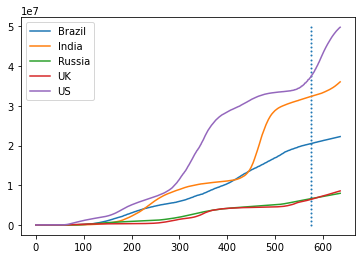

In [38]:
plt.figure()
plt.plot(bra)
plt.plot(ind)
plt.plot(rus)
plt.plot(UK)
plt.plot(US)
plt.scatter([timeLength for _ in range(50)],np.linspace(0,np.max(US)),s=1)
plt.legend(['Brazil','India','Russia','UK','US'])